# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications.xception import Xception
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [3]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_2_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 299, 299, 3)


# Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_Xception_data_aug_2_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 125,720,105
Trainable params: 125,665,577
Non-trainable params: 54,528
_________________________________________________________________


for i, layer in enumerate(model.layers):
   print(i, layer.name)

In [7]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True        

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_Xception_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_Xception_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 11s - loss: 0.1013 - acc: 0.9815 - val_loss: 0.0037 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00368, saving model to tl_fine_tuning_Xception_2_breeds
Epoch 2/1000
 - 5s - loss: 0.0055 - acc: 0.9954 - val_loss: 1.6716e-06 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00368 to 0.00000, saving model to tl_fine_tuning_Xception_2_breeds
Epoch 3/1000
 - 4s - loss: 0.0940 - acc: 0.9769 - val_loss: 0.0093 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/1000
 - 4s - loss: 0.0567 - acc: 0.9861 - val_loss: 0.0037 - val_acc: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/1000
 - 4s - loss: 0.0305 - acc: 0.9955 - val_loss: 0.0038 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/1000
 - 4s - loss: 0.0390 - acc: 0.9906 - val_loss: 0.0019 - val_acc: 1.0000

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/1000
 - 4s - loss: 0.0130 - acc: 0.9954 - val_loss: 9.4342e-0

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 1s 21ms/step


[0.001269311909717204, 1.0]

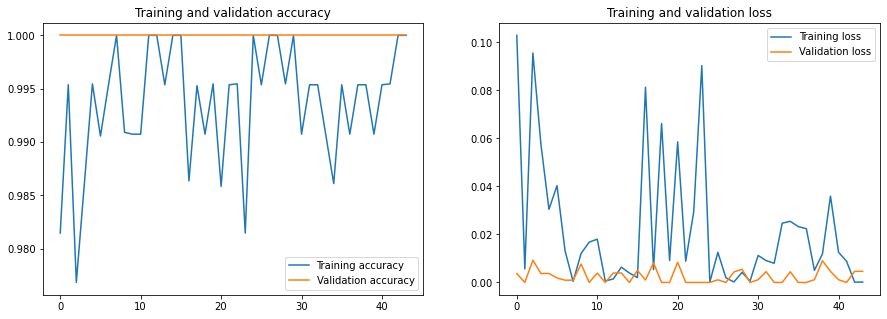

In [10]:
plot_accuracy_and_loss(history)

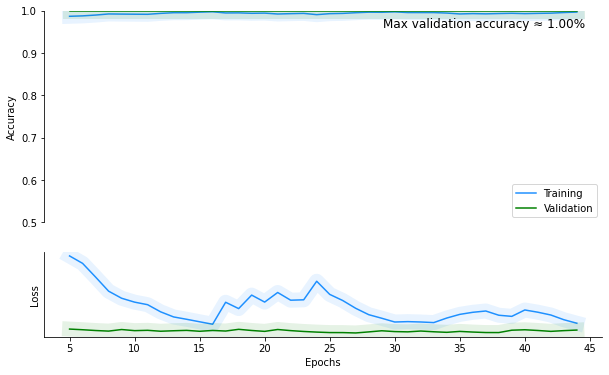

In [11]:
plot_history(history,xkcd=False)

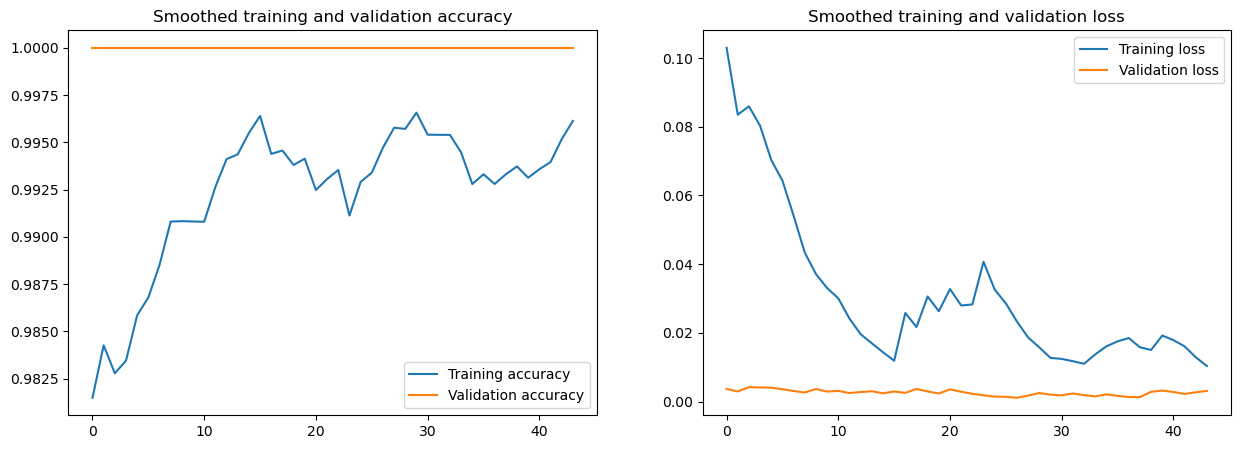

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_3_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 299, 299, 3)


## Model

In [14]:
model = load_model(PATH + 'tl_freeze_conv_base_Xception_data_aug_3_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 125,721,131
Trainable params: 125,666,603
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_Xception_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_Xception_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 9s - loss: 0.0507 - acc: 0.9847 - val_loss: 1.1937e-05 - val_acc: 0.9875

Epoch 00001: val_loss improved from inf to 0.00001, saving model to tl_fine_tuning_Xception_3_breeds
Epoch 2/1000
 - 8s - loss: 0.0088 - acc: 0.9974 - val_loss: 0.1547 - val_acc: 0.9706

Epoch 00002: val_loss did not improve from 0.00001
Epoch 3/1000
 - 8s - loss: 0.0280 - acc: 0.9949 - val_loss: 0.2387 - val_acc: 0.9706

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/1000
 - 8s - loss: 0.0507 - acc: 0.9925 - val_loss: 4.2319e-07 - val_acc: 0.9853

Epoch 00004: val_loss improved from 0.00001 to 0.00000, saving model to tl_fine_tuning_Xception_3_breeds
Epoch 5/1000
 - 7s - loss: 0.0357 - acc: 0.9923 - val_loss: 0.0072 - val_acc: 0.9706

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/1000
 - 8s - loss: 0.0257 - acc: 0.9898 - val_loss: 0.2422 - val_acc: 0.9750

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/1000
 - 7s - loss: 0.0257 - acc: 0.9923 - val_loss: 9.4288

## Results

In [18]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 1s 16ms/step


[0.0033839736136042887, 1.0]

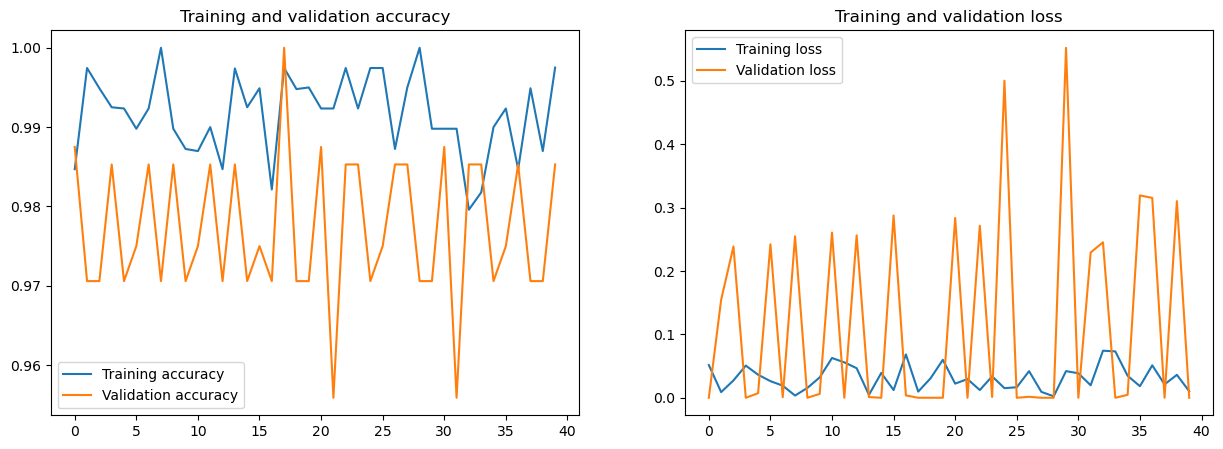

In [19]:
plot_accuracy_and_loss(history)

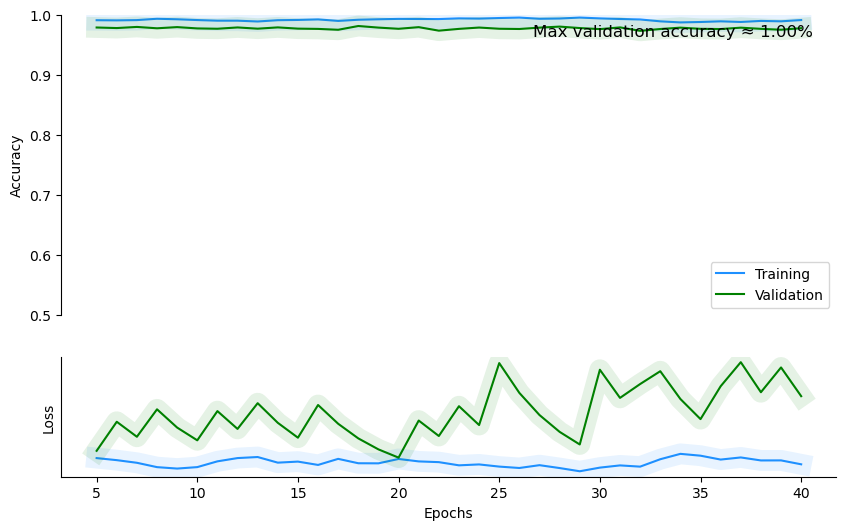

In [20]:
plot_history(history,xkcd=False)

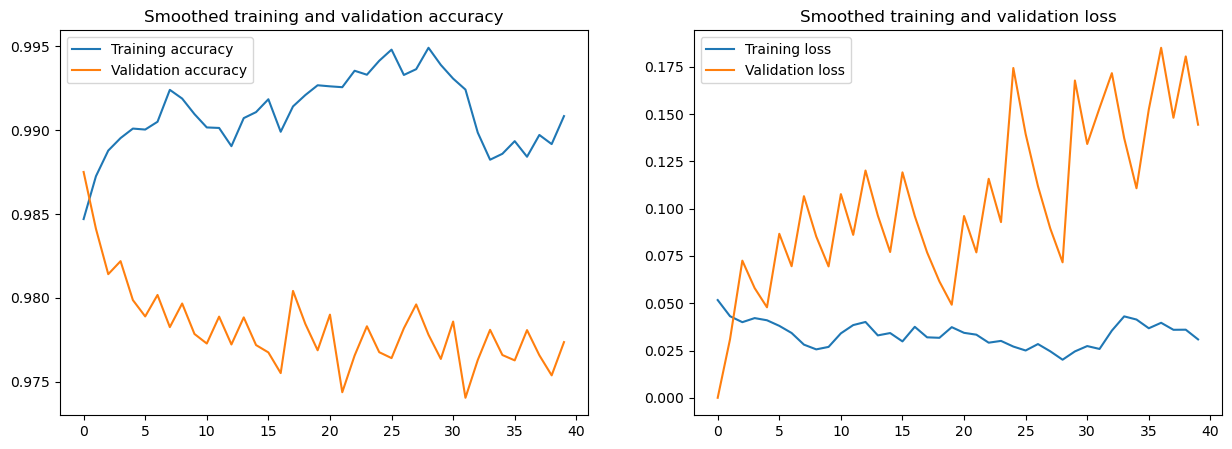

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

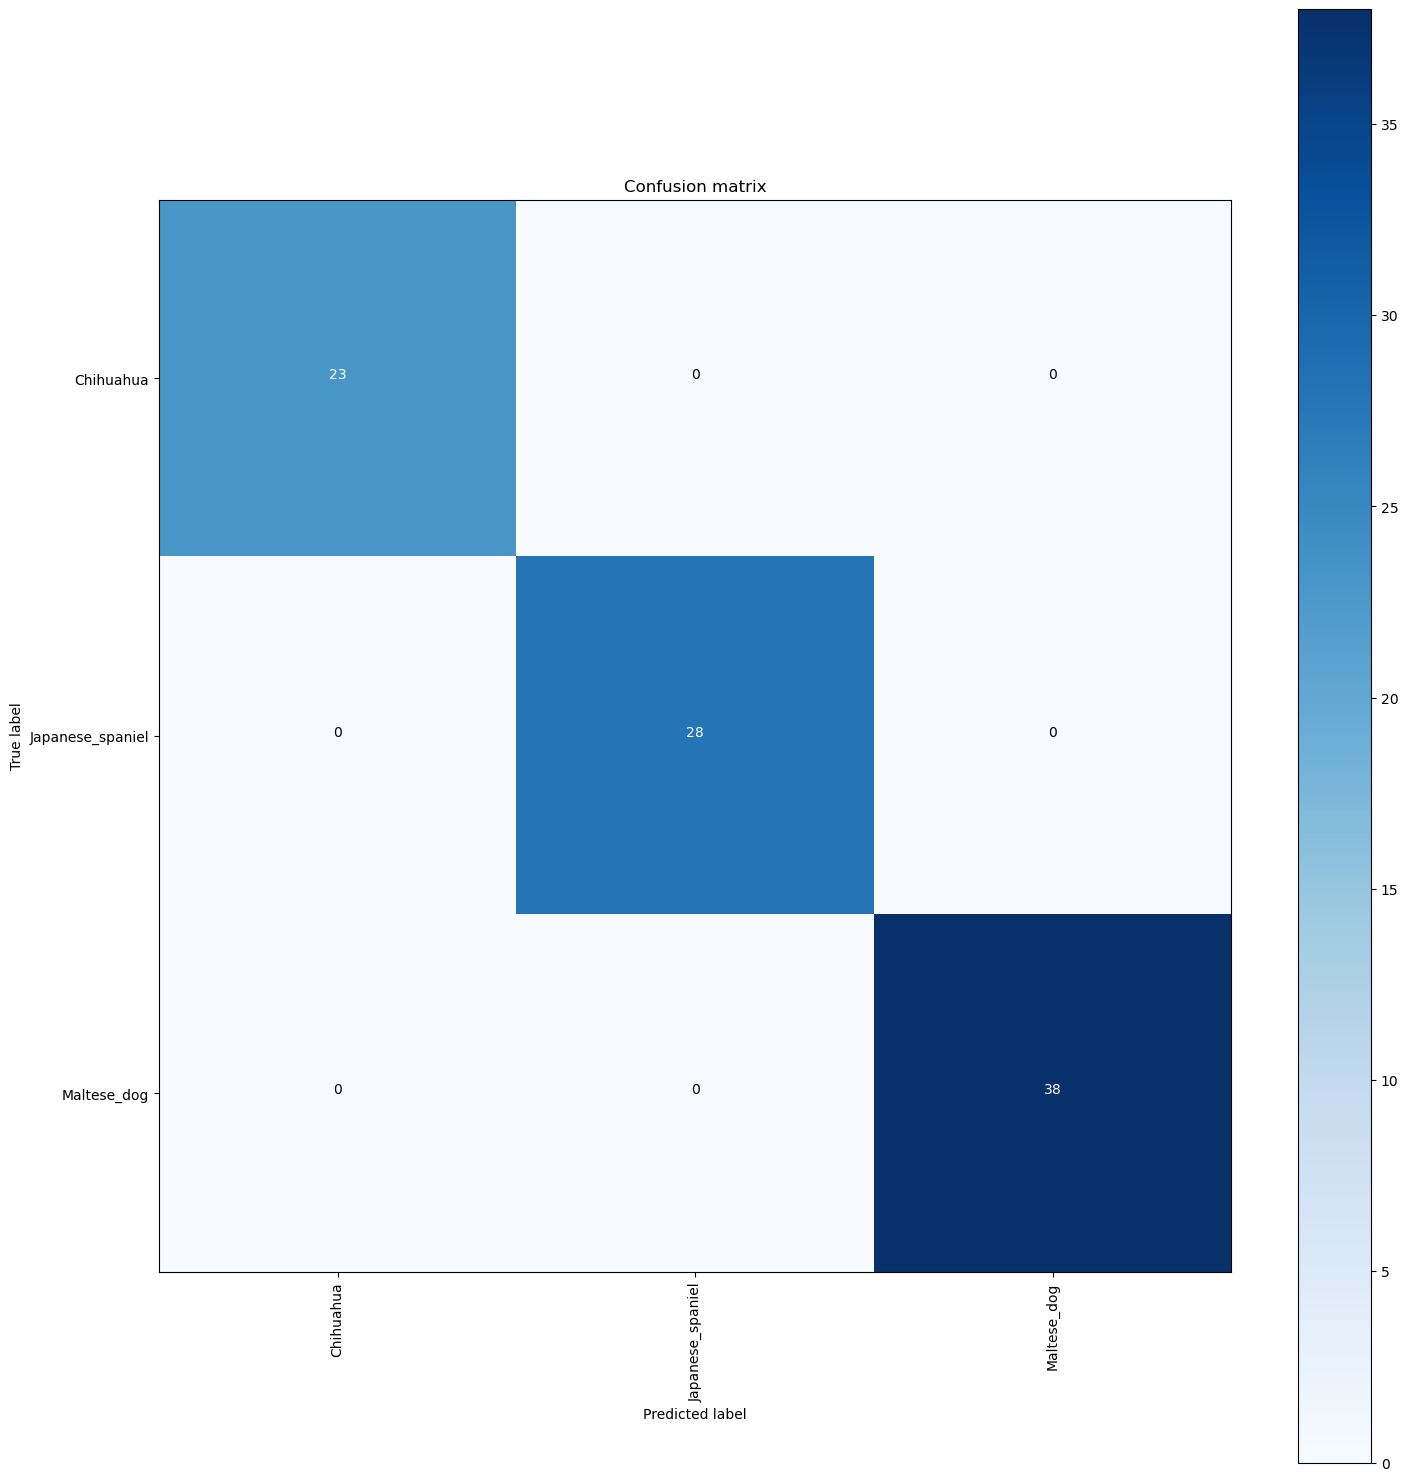

In [22]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [23]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_5_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 299, 299, 3)


## Model

In [24]:
model = load_model(PATH + 'tl_freeze_conv_base_Xception_data_aug_5_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 125,722,157
Trainable params: 125,667,629
Non-trainable params: 54,528
_________________________________________________________________


In [26]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_Xception_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_Xception_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 15s - loss: 0.1640 - acc: 0.9536 - val_loss: 0.1645 - val_acc: 0.9214

Epoch 00001: val_loss improved from inf to 0.16446, saving model to tl_fine_tuning_Xception_5_breeds
Epoch 2/1000
 - 14s - loss: 0.1614 - acc: 0.9427 - val_loss: 0.6259 - val_acc: 0.9187

Epoch 00002: val_loss did not improve from 0.16446
Epoch 3/1000
 - 13s - loss: 0.1751 - acc: 0.9412 - val_loss: 0.2554 - val_acc: 0.9350

Epoch 00003: val_loss did not improve from 0.16446
Epoch 4/1000
 - 13s - loss: 0.1589 - acc: 0.9551 - val_loss: 0.5291 - val_acc: 0.9187

Epoch 00004: val_loss did not improve from 0.16446
Epoch 5/1000
 - 13s - loss: 0.2157 - acc: 0.9318 - val_loss: 0.6258 - val_acc: 0.9350

Epoch 00005: val_loss did not improve from 0.16446
Epoch 6/1000
 - 12s - loss: 0.1119 - acc: 0.9541 - val_loss: 0.1979 - val_acc: 0.9431

Epoch 00006: val_loss did not improve from 0.16446
Epoch 7/1000
 - 12s - loss: 0.1679 - acc: 0.9621 - val_loss: 0.2755 - val_acc: 0.9350

Epoch 00007: val_loss did not impro

## Results

In [28]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 2s 11ms/step


[0.1514795012446446, 0.9580419659614563]

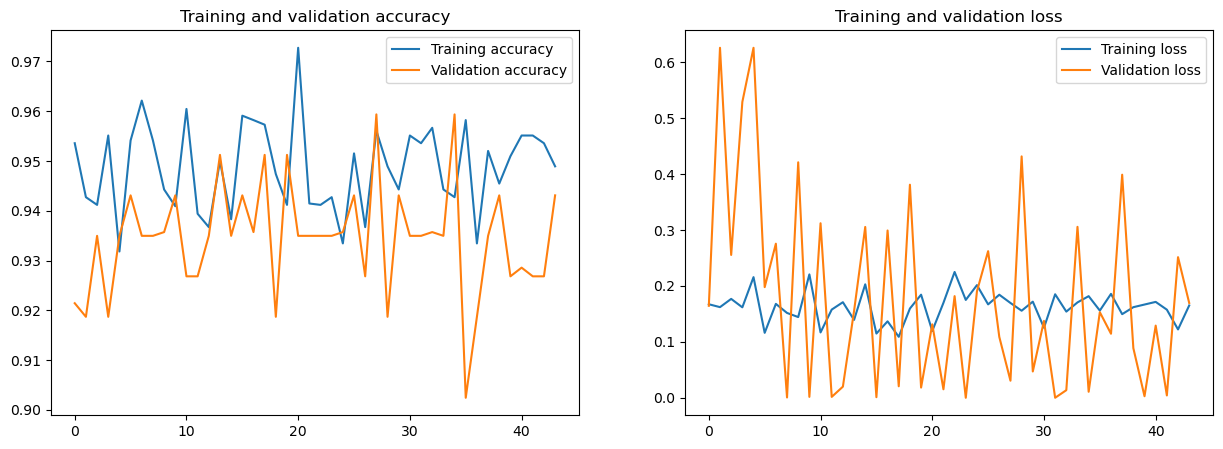

In [29]:
plot_accuracy_and_loss(history)

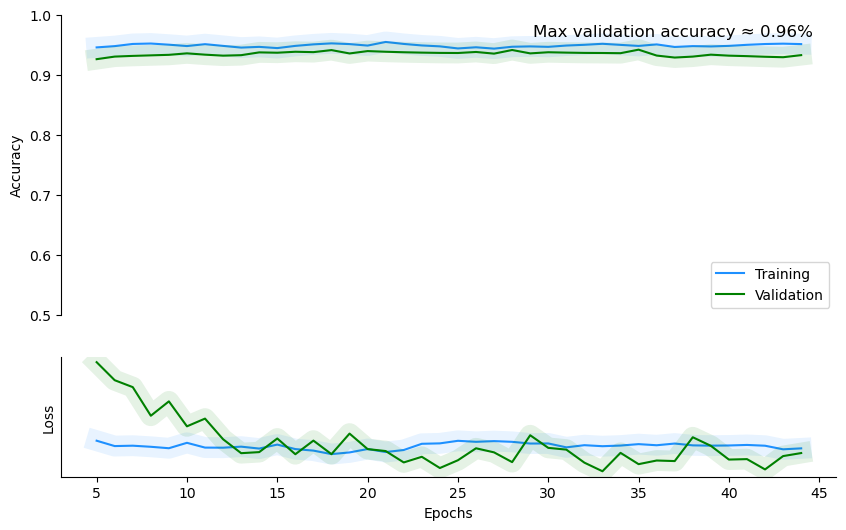

In [30]:
plot_history(history,xkcd=False)

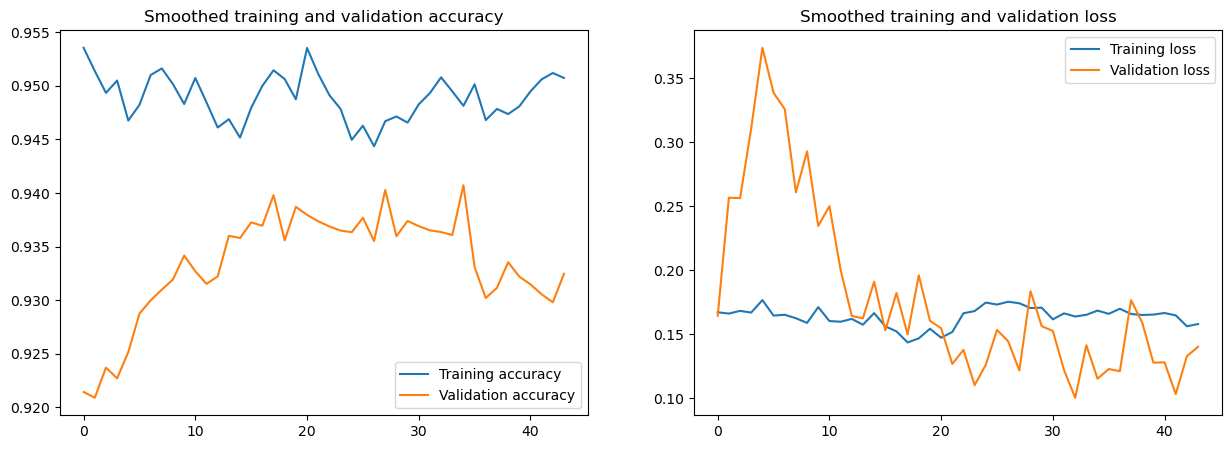

In [31]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

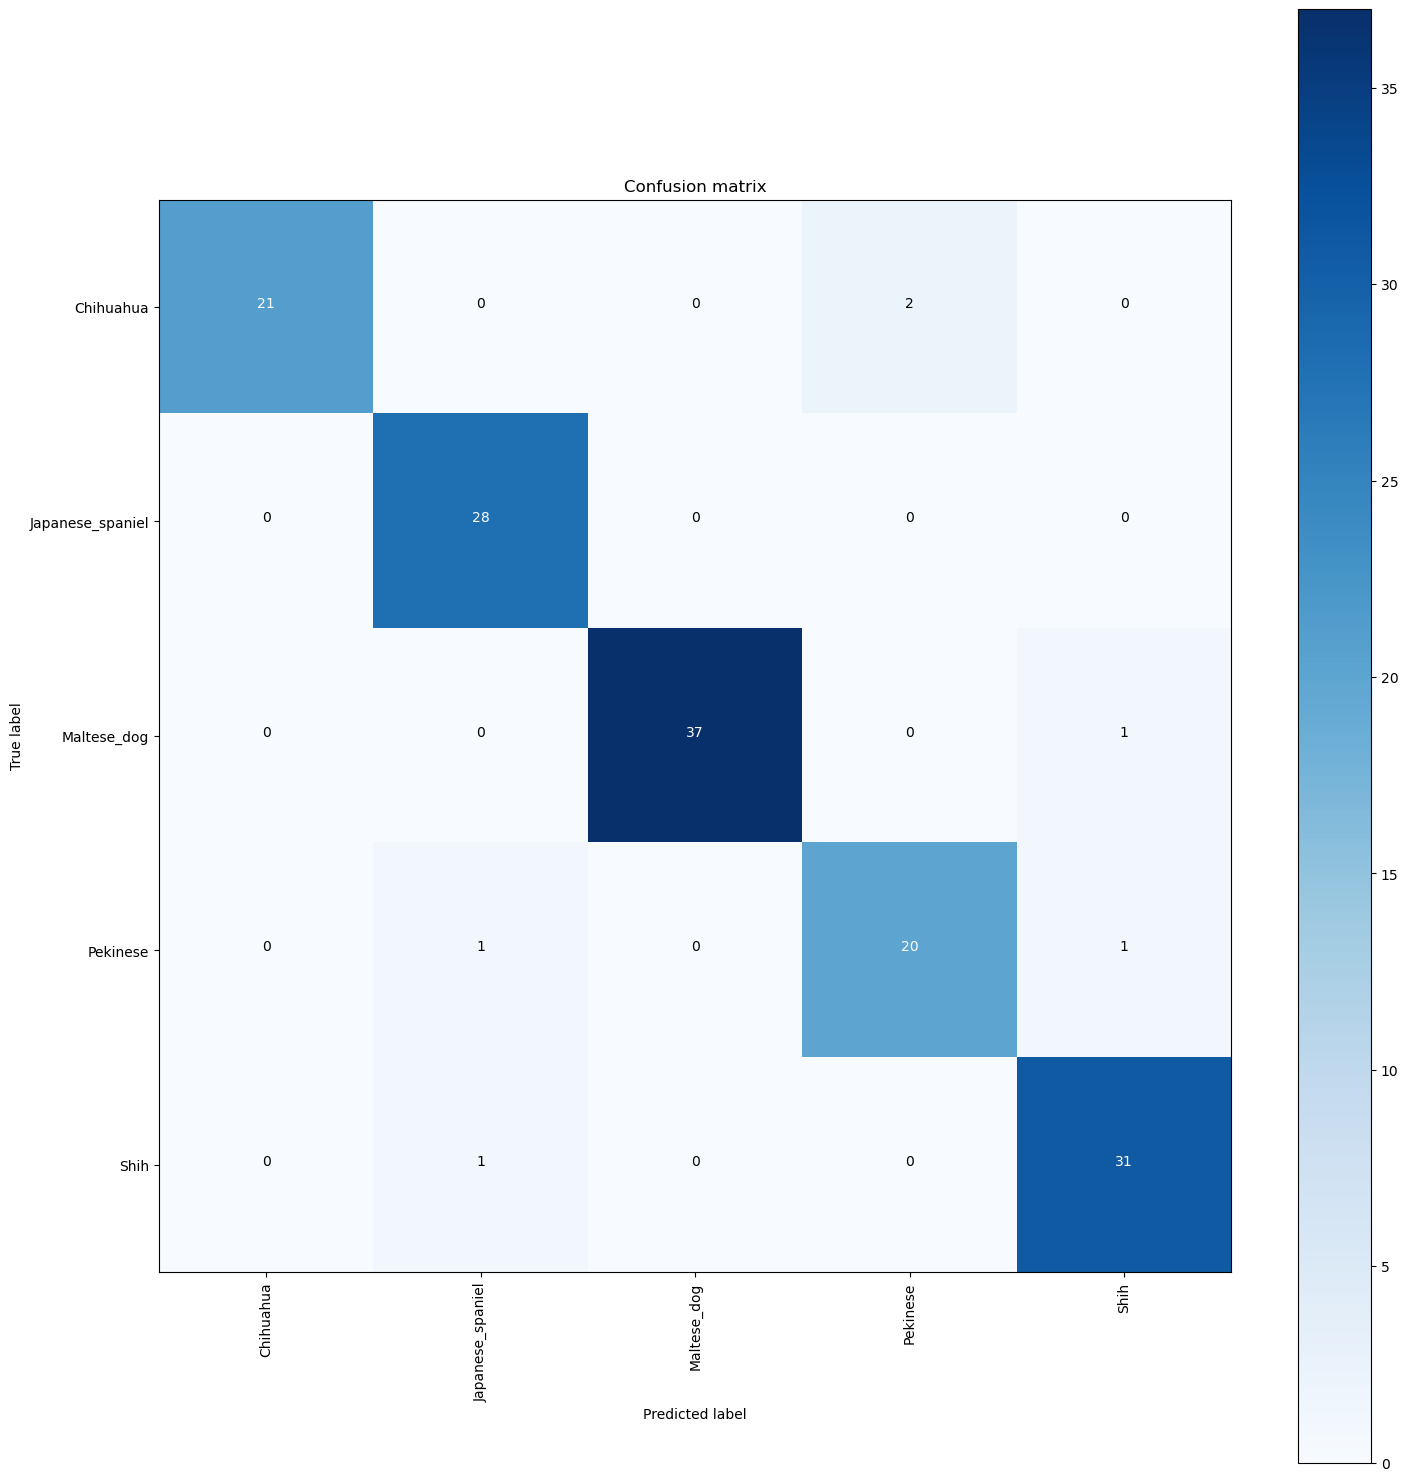

In [32]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [33]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_60_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [34]:
model = load_model(PATH + 'tl_freeze_conv_base_data_Xception_aug_60_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                30780     
Total params: 125,750,372
Trainable params: 125,695,844
Non-trainable params: 54,528
_________________________________________________________________


In [36]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_Xception_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_Xception_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 155s - loss: 1.0346 - acc: 0.8039 - val_loss: 1.3161e-04 - val_acc: 0.9388

Epoch 00001: val_loss improved from inf to 0.00013, saving model to tl_fine_tuning_Xception_60_breeds
Epoch 2/1000
 - 148s - loss: 1.0214 - acc: 0.8098 - val_loss: 0.6851 - val_acc: 0.9390

Epoch 00002: val_loss did not improve from 0.00013
Epoch 3/1000
 - 146s - loss: 1.0138 - acc: 0.8101 - val_loss: 0.4033 - val_acc: 0.9396

Epoch 00003: val_loss did not improve from 0.00013
Epoch 4/1000
 - 146s - loss: 1.0578 - acc: 0.8117 - val_loss: 0.3531 - val_acc: 0.9356

Epoch 00004: val_loss did not improve from 0.00013
Epoch 5/1000
 - 147s - loss: 0.9517 - acc: 0.8185 - val_loss: 0.1581 - val_acc: 0.9409

Epoch 00005: val_loss did not improve from 0.00013
Epoch 6/1000
 - 147s - loss: 0.9399 - acc: 0.8191 - val_loss: 5.9554e-05 - val_acc: 0.9390

Epoch 00006: val_loss improved from 0.00013 to 0.00006, saving model to tl_fine_tuning_Xception_60_breeds
Epoch 7/1000
 - 148s - loss: 0.9082 - acc: 0.8229 - 

## Results

In [38]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 20s 13ms/step


[0.3280312906647047, 0.9351851940155029]

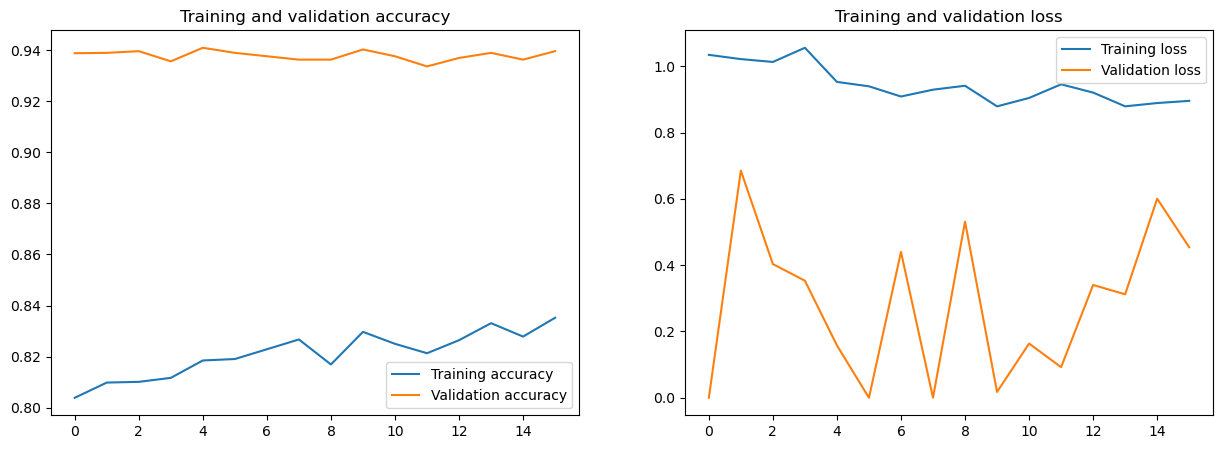

In [39]:
plot_accuracy_and_loss(history)

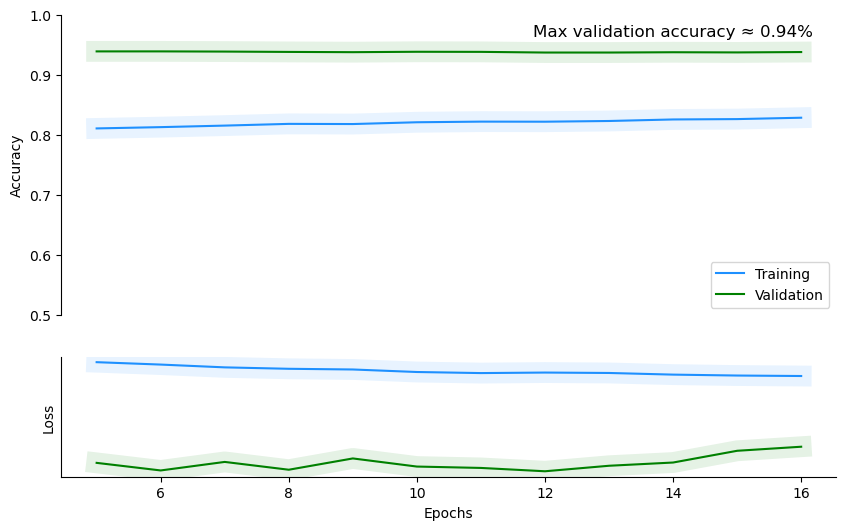

In [40]:
plot_history(history,xkcd=False)

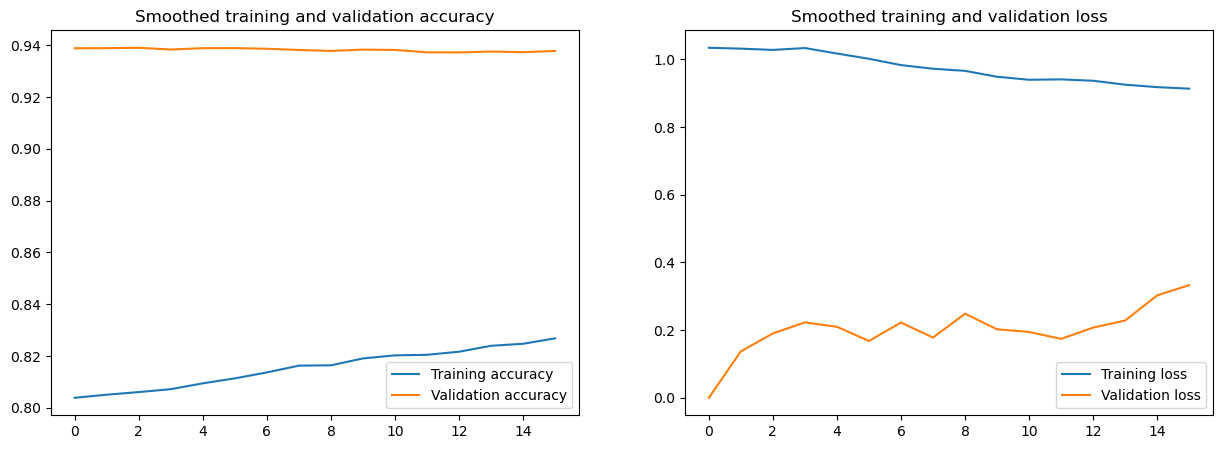

In [41]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

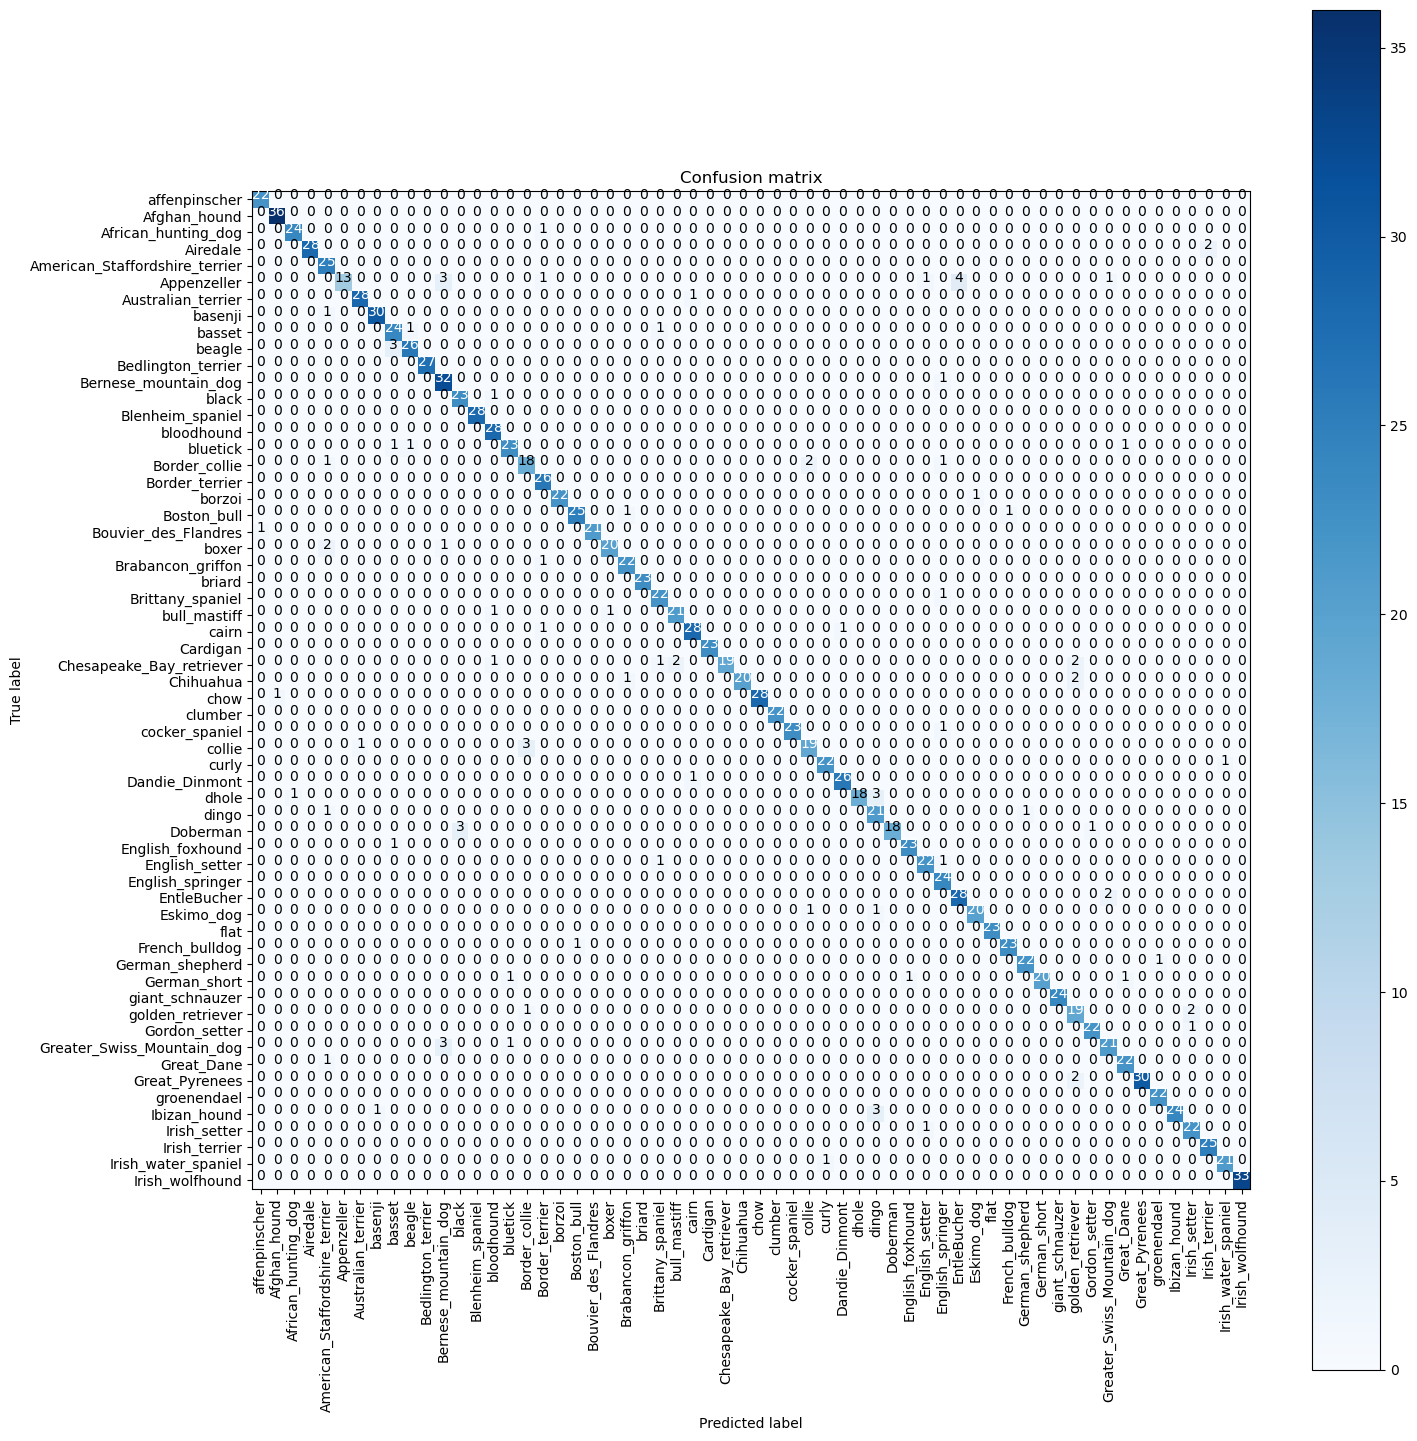

In [42]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_120_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [44]:
model = load_model(PATH + 'tl_freeze_conv_base_Xception_data_aug_120_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 125,781,152
Trainable params: 125,726,624
Non-trainable params: 54,528
_________________________________________________________________


In [46]:
set_trainable = False
      
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True   

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_Xception_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_Xception_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 322s - loss: 1.4930 - acc: 0.7035 - val_loss: 0.2739 - val_acc: 0.8740

Epoch 00001: val_loss improved from inf to 0.27394, saving model to tl_fine_tuning_Xception_120_breeds
Epoch 2/1000
 - 302s - loss: 1.4936 - acc: 0.7102 - val_loss: 0.6117 - val_acc: 0.8740

Epoch 00002: val_loss did not improve from 0.27394
Epoch 3/1000
 - 301s - loss: 1.4603 - acc: 0.7077 - val_loss: 0.4614 - val_acc: 0.8727

Epoch 00003: val_loss did not improve from 0.27394
Epoch 4/1000
 - 304s - loss: 1.4239 - acc: 0.7198 - val_loss: 1.6535 - val_acc: 0.8733

Epoch 00004: val_loss did not improve from 0.27394
Epoch 5/1000
 - 299s - loss: 1.4417 - acc: 0.7156 - val_loss: 0.2894 - val_acc: 0.8740

Epoch 00005: val_loss did not improve from 0.27394
Epoch 6/1000
 - 302s - loss: 1.3937 - acc: 0.7216 - val_loss: 0.1944 - val_acc: 0.8704

Epoch 00006: val_loss improved from 0.27394 to 0.19441, saving model to tl_fine_tuning_Xception_120_breeds
Epoch 7/1000
 - 295s - loss: 1.4372 - acc: 0.7184 - val_lo

## Results

In [48]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 44s 14ms/step


[0.5449319855236339, 0.880674421787262]

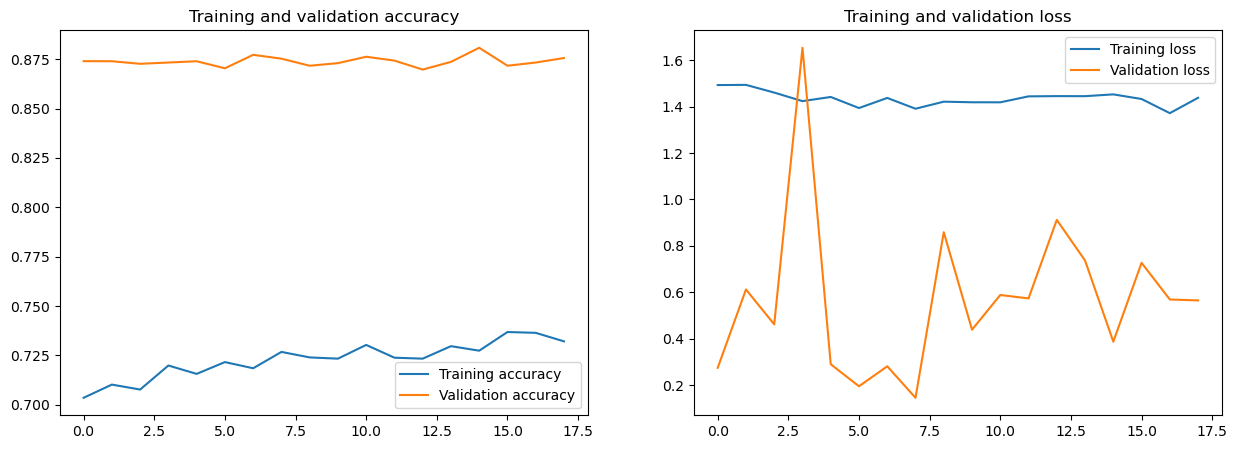

In [49]:
plot_accuracy_and_loss(history)

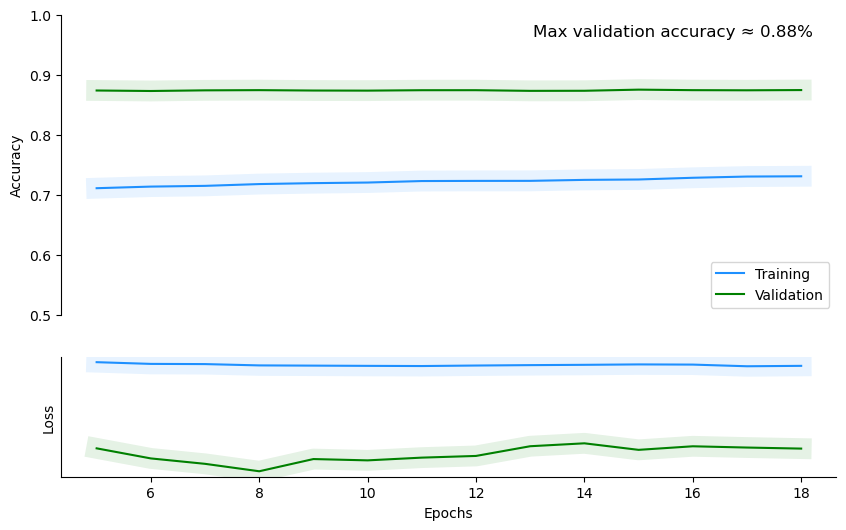

In [50]:
plot_history(history,xkcd=False)

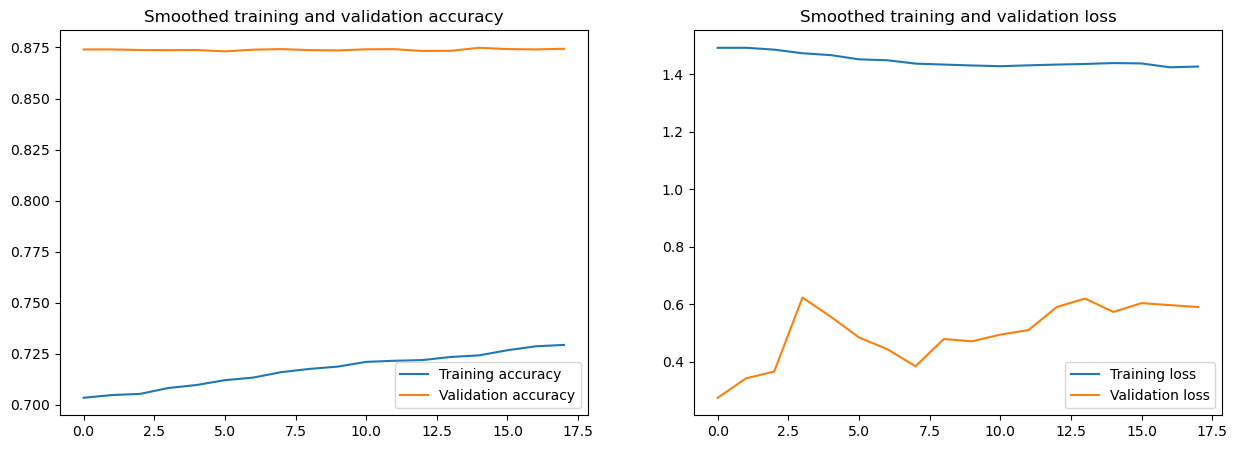

In [51]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

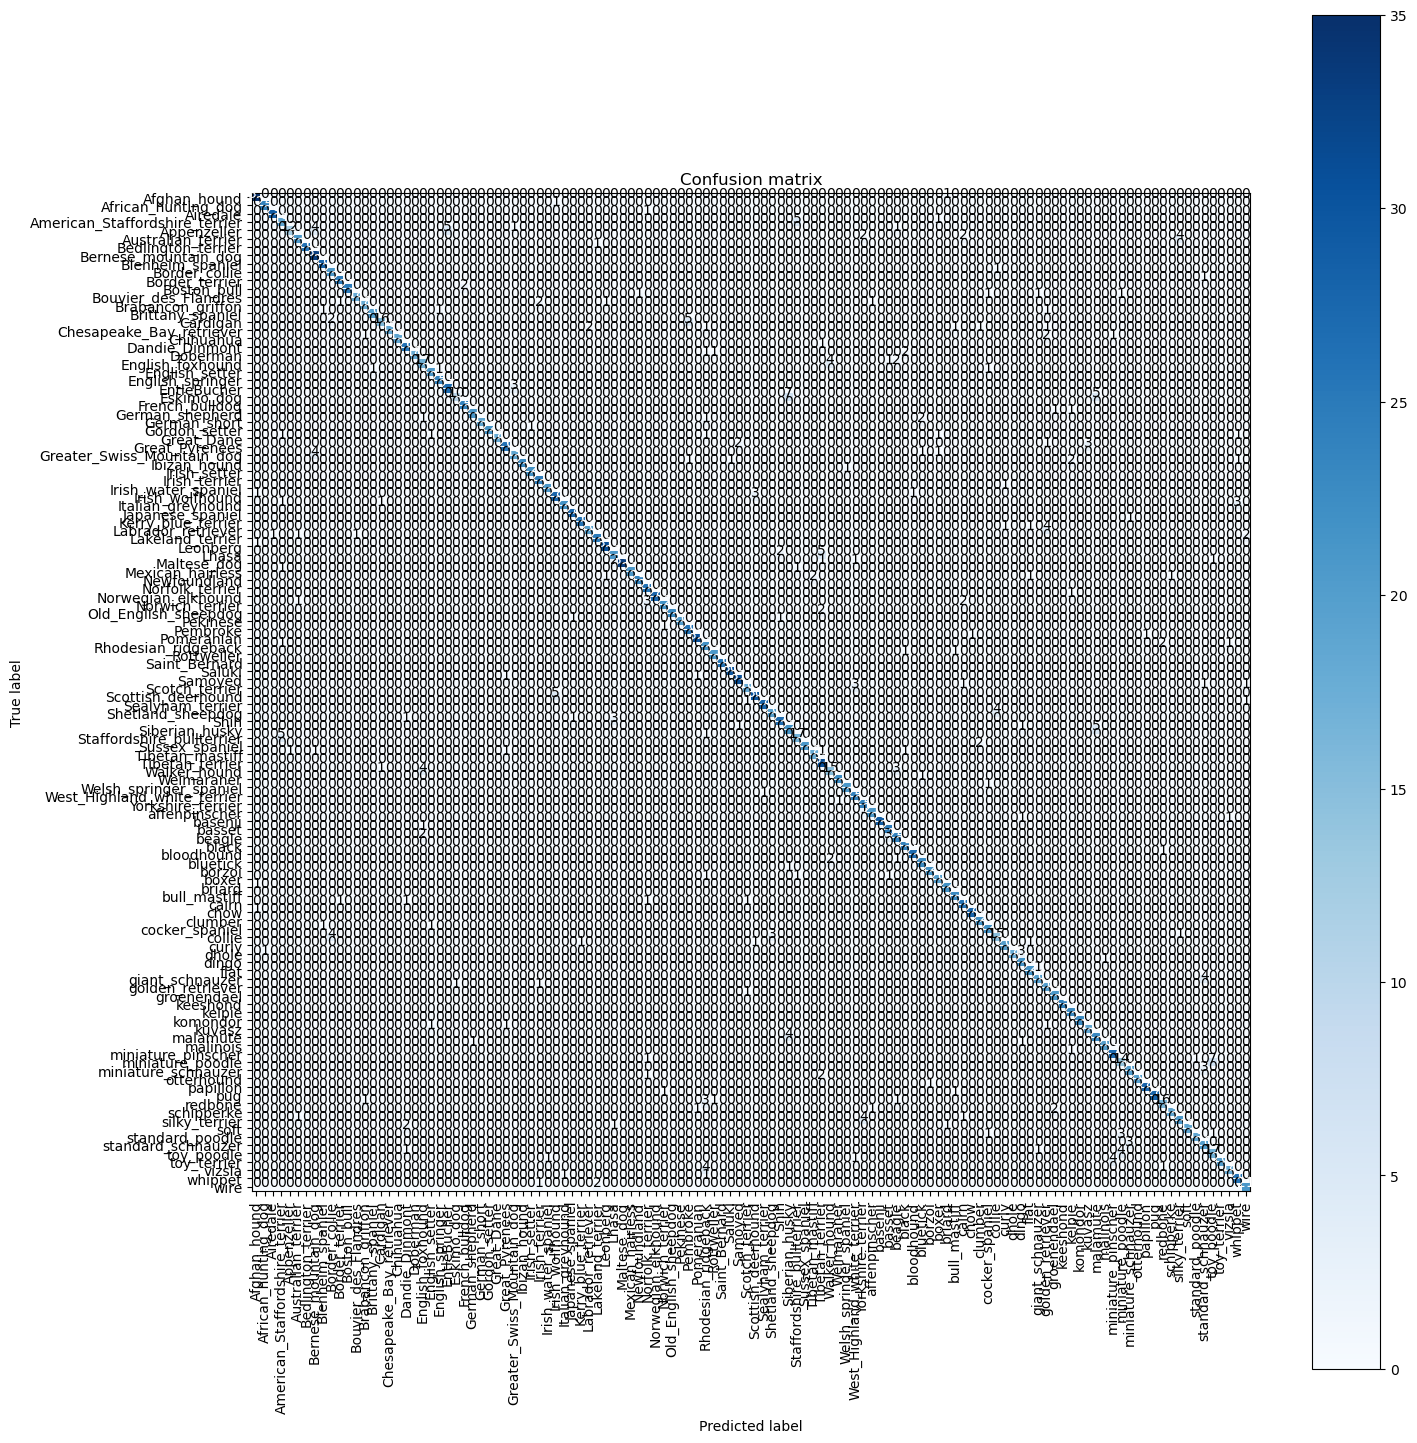

In [52]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()